# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=3,
                maxmagnitude=3.5,
                maxradiuskm=500, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 7 events


In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
6,us6000ipd3,2022-09-29 15:09:32.565,off the coast of Washington,47.637400,-128.921800,10.555,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168
5,uw61882431,2022-09-22 14:41:56.900,"26 km WNW of Forks, Washington",48.046500,-124.715000,37.040,3.49,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,190
4,uw61862977,2022-08-13 13:31:22.900,"21 km NW of Bickleton, Washington",46.130333,-120.500000,12.100,3.05,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,146
3,uw61860022,2022-08-04 13:22:39.400,"6 km SSE of Black Diamond, Washington",47.258667,-121.971833,21.540,3.06,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,250
2,uw61836427,2022-05-28 19:07:44.030,"55 km NE of Marblemount, Washington",48.807833,-120.822500,-0.060,3.16,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,157
1,us6000hn38,2022-05-22 09:58:57.424,"2 km WSW of Mullan, Idaho",47.458000,-115.834800,5.000,3.00,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,142
0,uw61832097,2022-05-17 08:07:34.400,"6 km ENE of Oso, Washington",48.299667,-121.852000,3.530,3.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,280


### Choose an event to analyze

In [4]:
this_event = event_df[event_df.id=='uw61832097']
t0 = this_event['time'].iloc[0]
this_id = this_event['id'][0]
this_event


,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,uw61832097,2022-05-17 08:07:34.400,"6 km ENE of Oso, Washington",48.299667,-121.852,3.53,3.4,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,280


### Load the DAS Data

In [ ]:
#calling inputs
cable = 'whidbey'
record_length = 7 #minutes

prefix, network_name, datastore = data_wrangler(cable,record_length,t0)

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
#open sintela return data, dates, attrs of this event
#data.shape[1] is x position
#data.shape[0] is time.
#x_max cable's position
x_max=data.shape[1] * attrs['SpatialSamplingInterval']
#low and hi_cut are the frequencies for the filter.
low_cut = 2
hi_cut = 10
#appliying filter passband
b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)



stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
           f"{this_event['location'].to_numpy()[0]}, "\
           f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"
      
filename = f"testsavingdataraw_event/"+this_id

timestamps = []
   

for d in dates:
    if type(d) == datetime.datetime:
        timestamps.append(int((d.timestamp()-25200)*10**6))
        #timestamps.append(int((d.timestamp())*10**6))
    else:
         timestamps.append(d)

g=h5py.File(filename+'.h5','w')
#g=h5py.File('this_id.h5','w')
g.create_dataset('Acquisition/Raw[0]/RawData',data=data)
g.create_dataset('Acquisition/Raw[0]/RawDataTime',data=np.array(timestamps))
g['Acquisition'].attrs.update(attrs)   
g.close()
    
    

#plt.savefig("WhidbeyearthquakeOsowashington3")

#plt.close()

# Plotting the event normal processing data

In [5]:
client = Client("IRIS")

record_length = 7 #minutes
low_cut = 2
hi_cut = 10

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)



1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-05-17T08:07:34.008393Z - 2022-05-17T08:14:33.998393Z | 100.0 Hz, 42000 samples

In [ ]:
local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                       stitle,filename=None,das_vmax=2,
                         network_name=network_name,
                         skip_seismograms=False)
plt.show()

# Plotting the event from data set saved as g (new file.h5)


In [11]:
chan_min=0
chan_max=-1

this_data1 = np.array([])
this_time1 = np.array([])


data_file = h5py.File('testsavingdataraw_event/uw61832097.h5','r')

this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
            
    
this_time1 = sintela_to_datetime(this_time)

this_data1 = this_data
attrs1=dict(data_file['Acquisition'].attrs)
    

            

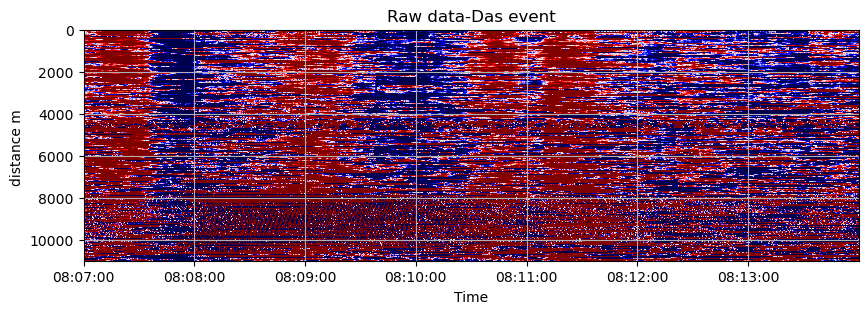

In [12]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.dates as mdates

#date_format = mdates.DateFormatter('%H:%M:%S')

date_format = mdates.DateFormatter('%H:%M:%S')
x_lims1 = mdates.date2num(this_time1)
x_max = this_data1.shape[1] * attrs1['SpatialSamplingInterval']
fig,ax=plt.subplots(figsize=(10,3))
plt.imshow(this_data1.T,cmap='seismic',aspect='auto',vmin=-0.2,vmax=0.2,extent=[x_lims1[0],x_lims1[-1],x_max,0])
plt.title('Raw data-Das event')
plt.xlabel("Time")
plt.ylabel("distance m ")

ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
plt.grid()
plt.show()

In [ ]:
#sanity checking comparing dates of event in UTC FORMAT
print({this_time1[0]}) # newfile
print({dates[0]}) #old


In [8]:
low_cut1 = 2
hi_cut1 = 10

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=attrs1['MaximumFrequency']*2)
data_filt2 = filtfilt(b,a,this_data1,axis=0)

# plotting the files saved

In [9]:


stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
           f"{this_event['location'].to_numpy()[0]}, "\
           f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"
cable = 'whidbey'

prefix = 'whidbey'
network_name='Whidbey-DAS'

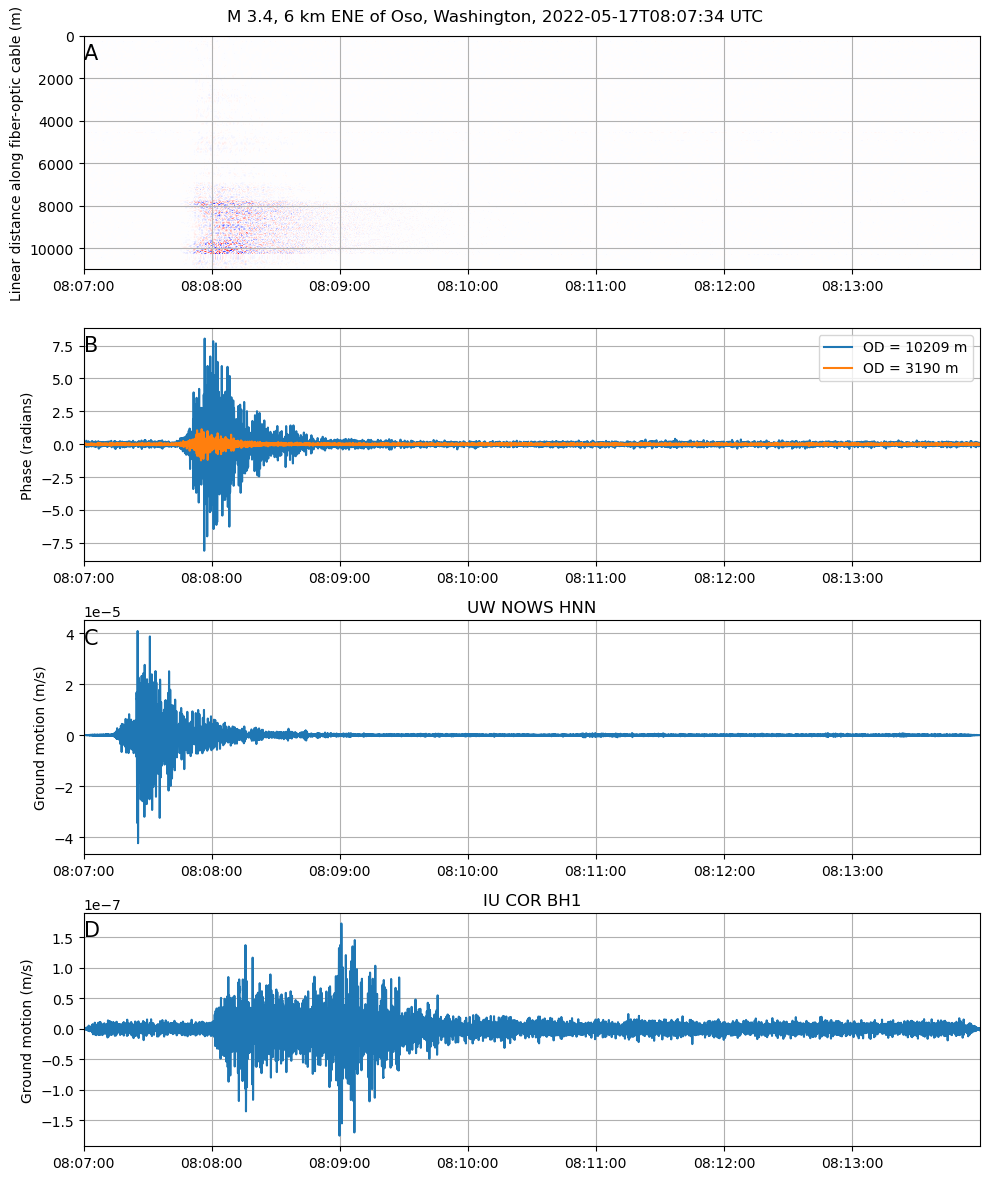

In [10]:
local_earthquake_quicklook(this_time1,data_filt2,st,st2,x_max,
                       stitle,filename=None,das_vmax=2,
                         network_name=network_name,
                         skip_seismograms=False)

# Transfer function usin UW station st


ValueError: x and y must have same first dimension, but have shapes (1,) and (42000, 42000)

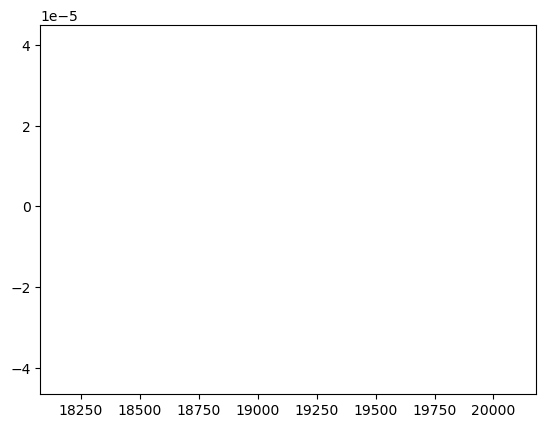

In [13]:
#attemp, work in progress.
epsilon=data_filt2[:,500]
epsilon1=data_filt2[:,1600]
velocity=np.array(st)
times_from_das = np.linspace(x_lims1[0],x_lims1[-1],len(velocity))
ratio=velocity.T[0:len(epsilon1)]/epsilon1
plt.plot(times_from_das,velocity)
plt.plot(times_from_das,ratio)
plt.show()

    

In [ ]:
velocity

In [ ]:
st.plot()